In [70]:
import numpy as np 
from random import random
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import os
from PIL import Image
import io
%matplotlib inline

In [2]:
def sandpile_model(grid_length: int, threshold: float=0.2, run_until: int=1):

    # initialise grid
    grid = np.zeros(grid_length)

    # list to hold historic of sandpile
    historic = []
    historic.append(grid.copy())

    # list to hold times of avalanches
    avtimes = []

    # initialise variables for sandpile model
    avalanche = False
    time = 0
    swas = 0


    # run sandpile model
    while swas < run_until:
        
        # Add sand
        sandin = 0.01 * random()
        grid[0] = grid[0] + sandin
        
        # Check cells for avalanche conditions
        for i in range(1, len(grid)):
            
            if round(grid[i-1] - grid[i], 6) < threshold:
                # no avalanche conditions.-> 
                # avalanche doesnt start or if avalanche, it stops.
                if avalanche:
                    # remove last grid copy to avoid double
                    historic = historic[:-1]
                break
                
            elif round(grid[i-1] - grid[i], 6) >= threshold:
                # avalanche starts or continues
                if i == 1:
                    # If first cell, need to make sure avalanche 
                    # starts at threshold, not past it.
                    
                    # correct time
                    overby = grid[i-1] - grid[i] - threshold
                    needed_fraction = (sandin-overby)/sandin
                    corrected_time = 1 * needed_fraction
                    
                    # correct sand in grid
                    grid[i-1] = grid[i] + threshold
                
                # Sand is flattened across n + 1 cells
                sandtoshare = sum(grid[:i+1])/(i+1)
                for j in range(len(grid[:i+1])):
                    grid[j] = sandtoshare
                
                # Avalanche length
                avlench = i
                
                # if threshold passed in final cell,
                # systemwide avalanche -> grid empties
                if grid[-1] >= threshold:
                    grid = np.zeros(grid_length)
                    avlench = len(grid)
                    swas += 1
                
                # set avalanche in progress to true
                avalanche = True
                
                # add copy of grid, to see avalanche progression
                historic.append(grid.copy())
        
        if avalanche:
            avtimes.append((avlench, round(time,2)))
            avalanche = False
            time = time + corrected_time
        else:
            time += 1
        
        #add copy of grid to see sandpile progression
        historic.append(grid.copy())

    return historic, avtimes

In [95]:
# grid length = 16 (should be minimum 16 or even 32 to get decent statistical graphs later on, 
# else 8 is good for just making the gifs)
# threshold = 0.2
# number of systemwide avalances = 1
historic, avtimes = sandpile_model(8, 0.2, 1)

In [96]:
# To make figures of grid to stritch together with PIL to make gif
# Is quite heavy on processing so can just save images and set make_gif to false if you want and then
# make gif using imagemagick for example 

def make_sandpile_graphics(grid_list: list, make_gif=True, save_single_images=False) -> None:
    
    now = datetime.now().strftime('%Y%m%d-%H%M')
    
    Path(f"../figures/test_{now}").mkdir(parents=True, exist_ok=True)
    
    images = []
    
    for i, grid in enumerate(grid_list):
        fig, ax = plt.subplots(1, figsize=(6, 6))
        
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_xlim(0, len(grid_list[0])+1)
        
        ax.set_xticks([i for i in [2**j for j in list(range(len(grid_list[0])))] if i <= len(grid_list[0])])
        ax.set_ylabel('Sand height', fontsize=12)
        ax.set_xlabel('Cell', fontsize=12)
        ax.set_title(f'Sandpile at t = {i}', fontsize=14)
        
        ax.bar(range(1, len(grid_list[0])+1), grid, align='center')
        
        if save_single_images:
            plt.savefig(f'../figures/test_{now}/image_{str(i).zfill(4)}.png')
    
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi = 200)
        buf.seek(0)
        images.append(Image.open(buf).convert("RGB"))
        plt.close()
    
    if make_gif:
        images[0].save(f'../figures/test_{now}/sandpile.gif',
                   save_all=True, append_images=images[1:], optimize=False, compress_level=1,
                       duration=40, loop=1, quality=95)
    
    
        
    
    

In [97]:
make_sandpile_graphics(historic,make_gif=True,save_single_images=False)

In [90]:
# get list of time differences between avalanches of size n
# if n is False, gives time between aavalanches of all sizes
def time_between_avalanches_size_n(avalanche_times: list, n: int=False) -> list:
    if n:
        right_size = list(filter(lambda x: x[0] == n, avalanche_times))
    else:
        right_size = avalanche_times[:]
    diffs = [i[1] -j[1] for i,j in zip(right_size[1:], right_size[:-1])]

    return diffs

In [92]:
# plot distribution of waiting times between avalanches of size n
# if n is False, gives plot between aavalanches of all sizes
def plot_waiting_time_hist(all_times: list, av_size: int=False) -> None:
    
    waiting_times = time_between_avalanches_size_n(all_times, av_size)
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.hist(waiting_times, bins=np.linspace(min(waiting_times), max(waiting_times), 50))
    ax.set_xlabel('Waiting Time (t)', fontsize=12)
    ax.set_ylabel('#', fontsize=12)
    ax.set_title(f'Waiting Time for avalanches size {av_size}')
    #plt.savefig(f'waiting_time_dist_av_size_{av_size}.png', dpi=200)

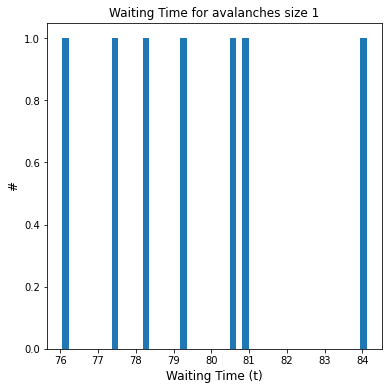

In [94]:
plot_waiting_time_hist(avtimes,1)